<a href="https://colab.research.google.com/github/kirti-github/emotion-detection-spectrograms/blob/main/emotion_detection_using_spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/'My Drive'/spectrograms.zip -d /content/spec_samples

In [ ]:
# Importing required libraries
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [ ]:
# Building the model
classifier=Sequential()

classifier.add(Conv2D(64,kernel_size=(3,3),input_shape=(288,288,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(BatchNormalization())

classifier.add(Conv2D(128,kernel_size=(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(BatchNormalization())

classifier.add(Conv2D(256,kernel_size=(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Flatten())

classifier.add(Dropout(rate=0.50))
classifier.add(Dense(units=128, activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Dense(units=5, activation='softmax'))

In [ ]:
#Compiling the model
classifier.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 286, 286, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 143, 143, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 143, 143, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 141, 141, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 70, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 70, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 68, 68, 256)       2

In [ ]:
# loading the training data
batch_size = 64

# Data augmentation such as shear, zoom are used. Here, flip, rotation are avoided since they dont hold relevance for this dataset.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2)

training_set = train_datagen.flow_from_directory(
        '/content/spec_samples/spectrograms/train',
        target_size=(288,288),   
        batch_size=30,
        seed=42,
        class_mode='categorical')

steps_per_epoch = training_set.n // training_set.batch_size

Found 670 images belonging to 5 classes.


In [ ]:
# loading the validation data
val_datagen = ImageDataGenerator(rescale=1./255)

val_set = val_datagen.flow_from_directory(
        '/content/spec_samples/spectrograms/val',
        target_size=(288,288),
        batch_size=30,
        shuffle=False,
        seed=42,
        class_mode='categorical')
validation_steps = val_set.n // val_set.batch_size

Found 140 images belonging to 5 classes.


In [ ]:
# Creating a model checkpoint to get the best model having the least loss
chkpt = ModelCheckpoint(filepath='best_model_mobnet.h5', save_best_only=True, monitor="val_loss", mode="auto",verbose=1)
hist_data=classifier.fit(
            training_set,
            steps_per_epoch=steps_per_epoch,
            epochs=100,
            validation_data=val_set,
            validation_steps = validation_steps,
            callbacks = chkpt)

Epoch 1/100
22/22 [==============================] - 51s 820ms/step - loss: 1.9103 - accuracy: 0.3012 - val_loss: 2.1749 - val_accuracy: 0.2333

Epoch 00001: val_loss improved from inf to 2.17485, saving model to best_model_mobnet.h5
Epoch 2/100
22/22 [==============================] - 17s 744ms/step - loss: 1.2939 - accuracy: 0.4663 - val_loss: 3.8662 - val_accuracy: 0.2333

Epoch 00002: val_loss did not improve from 2.17485
Epoch 3/100
22/22 [==============================] - 16s 736ms/step - loss: 1.2130 - accuracy: 0.5272 - val_loss: 4.3629 - val_accuracy: 0.2333

Epoch 00003: val_loss did not improve from 2.17485
Epoch 4/100
22/22 [==============================] - 16s 741ms/step - loss: 1.1670 - accuracy: 0.5419 - val_loss: 4.3489 - val_accuracy: 0.2333

Epoch 00004: val_loss did not improve from 2.17485
Epoch 5/100
22/22 [==============================] - 17s 743ms/step - loss: 1.1329 - accuracy: 0.5316 - val_loss: 4.4071 - val_accuracy: 0.2333

Epoch 00005: val_loss did not imp

In [ ]:
# Loading the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
        '/content/spec_samples/spectrograms/test',
        color_mode="rgb",
        target_size=(288,288),
        batch_size=1,
        shuffle=False,
        seed=42,
        class_mode='categorical')

Found 150 images belonging to 5 classes.


In [ ]:
# Loading the best model
from keras.models import load_model

classifier = load_model('best_model_mobnet.h5')

In [ ]:
# Getting the predictions
test_set.reset()

predictions=classifier.predict(test_set)

# Predicted classes
y_pred=np.argmax(predictions,axis=1)

# Actual classes
y_true = test_set.classes

In [ ]:
test_set.class_indices

{'angry': 0, 'fearful': 1, 'happy': 2, 'sad': 3, 'surprised': 4}

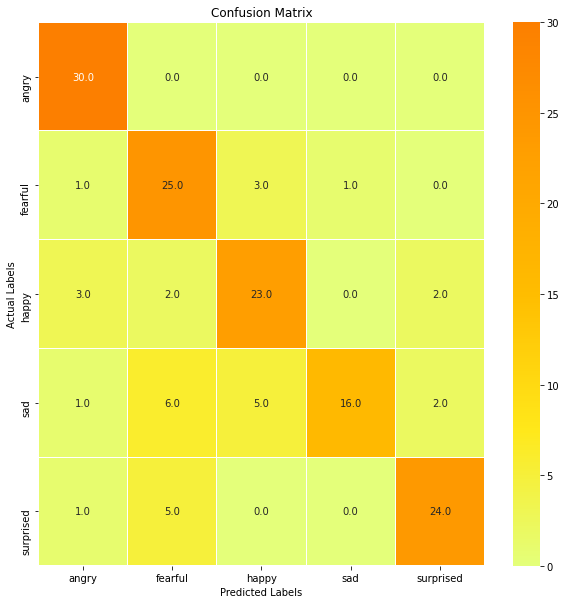

In [ ]:
# Plotting the confusion matrix
c_matrix=confusion_matrix(y_true, y_pred)
plot,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(c_matrix, annot=True, linewidths=0.05,cmap="Wistia", fmt= '.1f'
            ,ax=ax)
ax.set_xticklabels(test_set.class_indices)
ax.set_yticklabels(test_set.class_indices)

plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Generating classification report
print('Classification Report')
print(classification_report(y_true, y_pred, 
                            target_names=test_set.class_indices))

Classification Report
              precision    recall  f1-score   support

       angry       0.83      1.00      0.91        30
     fearful       0.66      0.83      0.74        30
       happy       0.74      0.77      0.75        30
         sad       0.94      0.53      0.68        30
   surprised       0.86      0.80      0.83        30

    accuracy                           0.79       150
   macro avg       0.81      0.79      0.78       150
weighted avg       0.81      0.79      0.78       150



In [ ]:
# Saving the model
classifier.save('emotion_det_spec_79.h5')

In [ ]:
# Saving the training history
json_file = 'emotion_det_spec_79.json' 

import pandas as pd
hist_datafr = pd.DataFrame(hist_data.history)
with open(json_file, mode='w') as jfile:
    hist_datafr.to_json(jfile)

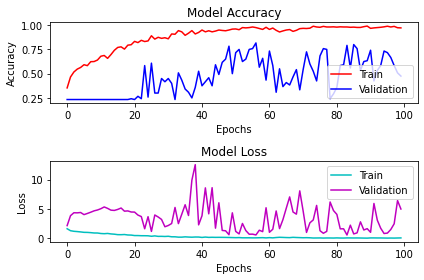

In [ ]:
import pandas as pd
train_hstry_df = pd.read_json(json_file).sort_index(axis=0)

fig = plt.figure()
# Plotting Accuracy of training and validation set
plt.subplot(2,1,1)
plt.plot(train_hstry_df['accuracy'],'r')
plt.plot(train_hstry_df['val_accuracy'],'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plotting loss of training and validation set
plt.subplot(2,1,2)
plt.plot(train_hstry_df['loss'],'c')
plt.plot(train_hstry_df['val_loss'],'m')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()